<a href="https://colab.research.google.com/github/head1ton/kaggle_dev/blob/master/Digit_Recognition_on_MNIST_NN%2Cdata_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import model_selection
from skimage.transform import rotate, rescale, resize, downscale_local_mean, warp, SimilarityTransform, AffineTransform
from skimage.morphology import thin, skeletonize
from skimage.util import invert

import seaborn as sns
sns.set(context='notebook', style='white', palette='deep')

import math

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./train.csv
./test.csv
./sample_submission.csv
./.config/active_config
./.config/.last_survey_prompt.yaml
./.config/gce
./.config/config_sentinel
./.config/.last_update_check.json
./.config/.metricsUUID
./.config/logs/2020.01.13/16.37.53.933238.log
./.config/logs/2020.01.13/16.37.37.002045.log
./.config/logs/2020.01.13/16.37.08.645258.log
./.config/logs/2020.01.13/16.37.40.784290.log
./.config/logs/2020.01.13/16.37.53.587497.log
./.config/logs/2020.01.13/16.37.24.945113.log
./.config/configurations/config_default
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/mnist_test.csv
./sample_data/california_housing_train.csv
./sample_data/california_housing_test.csv
./sample_data/mnist_train_small.csv


In [0]:
# utility functions
def extract_images_and_labels(data, is_test=False):
    n = data.shape[0]
    print("number of images: %s" %n)
    data_array = data.to_numpy(dtype=np.int32)
    if is_test:
        X = data_array.reshape(-1, 28, 28)
        print("Dimensions of images: {0}".format(X.shape))
        return X, n
    else:
        X = data_array[:, 1::].reshape(-1, 28, 28)
        y = data_array[:, 0].reshape([data_array.shape[0], 1])
        print("Dimensions of labels: %s and images: %s" %(y.shape, X.shape))
        return X, y, n

In [0]:
training_data = pd.read_csv('./train.csv')
testing_data = pd.read_csv('./test.csv')

In [4]:
print("number of training images : %d" %training_data.shape[0])
print("number of pixels per images : %d" %(training_data.shape[1]-1))
training_data.head()

number of training images : 42000
number of pixels per images : 784


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
X, y, n = extract_images_and_labels(training_data)

number of images: 42000
Dimensions of labels: (42000, 1) and images: (42000, 28, 28)


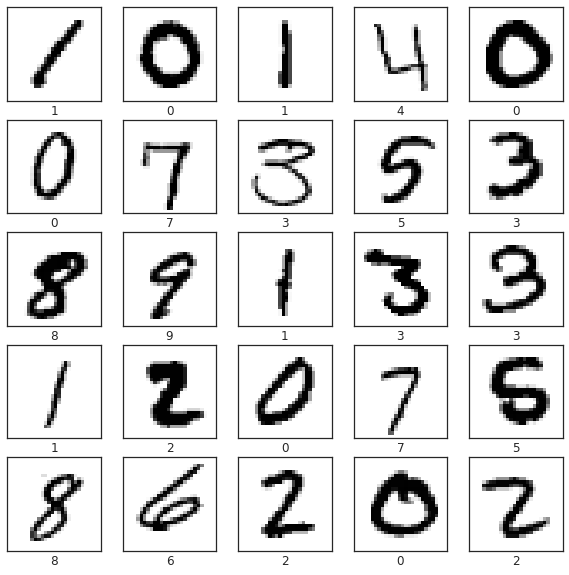

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i][0])
plt.show()

In [10]:
X.shape

(42000, 28, 28)

In [11]:
y.shape

(42000, 1)

In [12]:
y

array([[1],
       [0],
       [1],
       ...,
       [7],
       [6],
       [9]], dtype=int32)

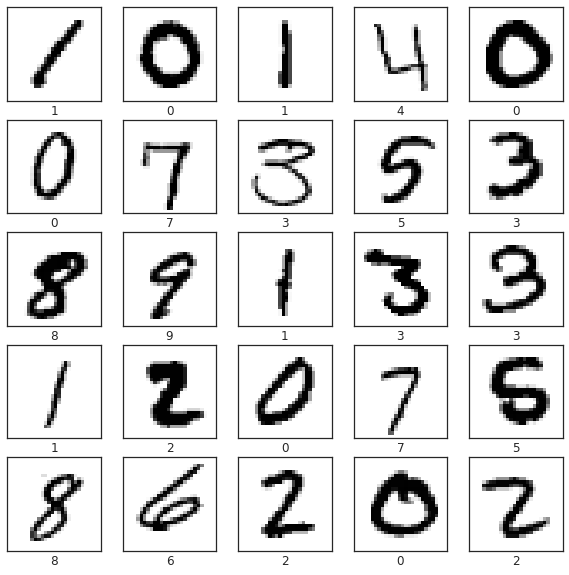

In [14]:
X_normalized = X / 255.0
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_normalized[i], cmap=plt.cm.binary)
    plt.xlabel(y[i][0])
plt.show()

In [15]:
# Neural Network
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(28,28)),
                          keras.layers.Dense(128*4, activation='relu'),
                          keras.layers.Dropout(0.5),
                          keras.layers.Dense(128*2, activation='relu'),
                          keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
# Prepare validation and training data sets
X_norm_train, X_norm_validation, y_train, y_validation = model_selection.train_test_split(
    X_normalized, 
    y, 
    test_size=0.33, 
    random_state=42)

In [19]:
# Train the neurl network
epochs = 100
validation_split = 0.33
earlystop_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00001,
    patience=3
)
model.fit(X_norm_train, 
          y_train, 
          epochs=epochs, 
          validation_split=validation_split,
          callbacks=[earlystop_callback])

Train on 18853 samples, validate on 9287 samples
Epoch 1/100
18853/18853 [==============================] - 4s 223us/sample - loss: 0.4006 - acc: 0.8770 - val_loss: 0.1786 - val_acc: 0.9475
Epoch 2/100
18853/18853 [==============================] - 4s 218us/sample - loss: 0.2041 - acc: 0.9362 - val_loss: 0.1590 - val_acc: 0.9522
Epoch 3/100
18853/18853 [==============================] - 4s 220us/sample - loss: 0.1557 - acc: 0.9502 - val_loss: 0.1351 - val_acc: 0.9621
Epoch 4/100
18853/18853 [==============================] - 4s 206us/sample - loss: 0.1237 - acc: 0.9593 - val_loss: 0.1285 - val_acc: 0.9613
Epoch 5/100
18853/18853 [==============================] - 4s 201us/sample - loss: 0.1093 - acc: 0.9651 - val_loss: 0.1126 - val_acc: 0.9667
Epoch 6/100
18853/18853 [==============================] - 4s 208us/sample - loss: 0.1015 - acc: 0.9664 - val_loss: 0.1146 - val_acc: 0.9697
Epoch 7/100
18853/18853 [==============================] - 4s 206us/sample - loss: 0.0875 - acc: 0.9720 -

In [20]:
# Evaluate performance
validation_loss, validation_accuracy = model.evaluate(X_norm_validation, y_validation, verbose=2)
print("Accuracy : %.4f, Loss : %.4f" %(validation_accuracy, validation_loss))

13860/13860 - 1s - loss: 0.1702 - acc: 0.9783
Accuracy : 0.9783, Loss : 0.1702


In [0]:
# Enrich the training data
num_repeats = 3
df = training_data.copy()
df_repeated = pd.concat([df] * num_repeats, ignore_index=True)
data_copy = df_repeated.copy().to_numpy(dtype=np.int32)

def warp_image(image):
    image = (image / 255.0).reshape(28, 28)
    # image = warp(image, inverse_map=AffineTransform(shear=np.random.normal(0, 0, 2), translation=np.random.normal(-2, 2, (1, 2))))
    image = thin(image, max_iter=np.random.randint(0, 3))
    image = rotate(image, angle=np.random.normal(-10, 10))
    return image.flatten()

X_generated = np.apply_along_axis(lambda x: warp_image(x), 1, data_copy[:, 1::]).reshape(-1, 28, 28)
y_generated = data_copy[:, 0].reshape([data_copy.shape[0], 1])

X_augmented = np.concatenate((X_normalized, X_generated), axis=0)
y_augmented = np.concatenate((y, y_generated), axis=0)

0 0 image index 0 plt index 1
0 1 image index 42000 plt index 2
0 2 image index 84000 plt index 3
0 3 image index 126000 plt index 4
1 0 image index 1 plt index 5
1 1 image index 42001 plt index 6
1 2 image index 84001 plt index 7
1 3 image index 126001 plt index 8
2 0 image index 2 plt index 9
2 1 image index 42002 plt index 10
2 2 image index 84002 plt index 11
2 3 image index 126002 plt index 12
3 0 image index 3 plt index 13
3 1 image index 42003 plt index 14
3 2 image index 84003 plt index 15
3 3 image index 126003 plt index 16
4 0 image index 4 plt index 17
4 1 image index 42004 plt index 18
4 2 image index 84004 plt index 19
4 3 image index 126004 plt index 20
5 0 image index 5 plt index 21
5 1 image index 42005 plt index 22
5 2 image index 84005 plt index 23
5 3 image index 126005 plt index 24
6 0 image index 6 plt index 25
6 1 image index 42006 plt index 26
6 2 image index 84006 plt index 27
6 3 image index 126006 plt index 28
7 0 image index 7 plt index 29
7 1 image index 420

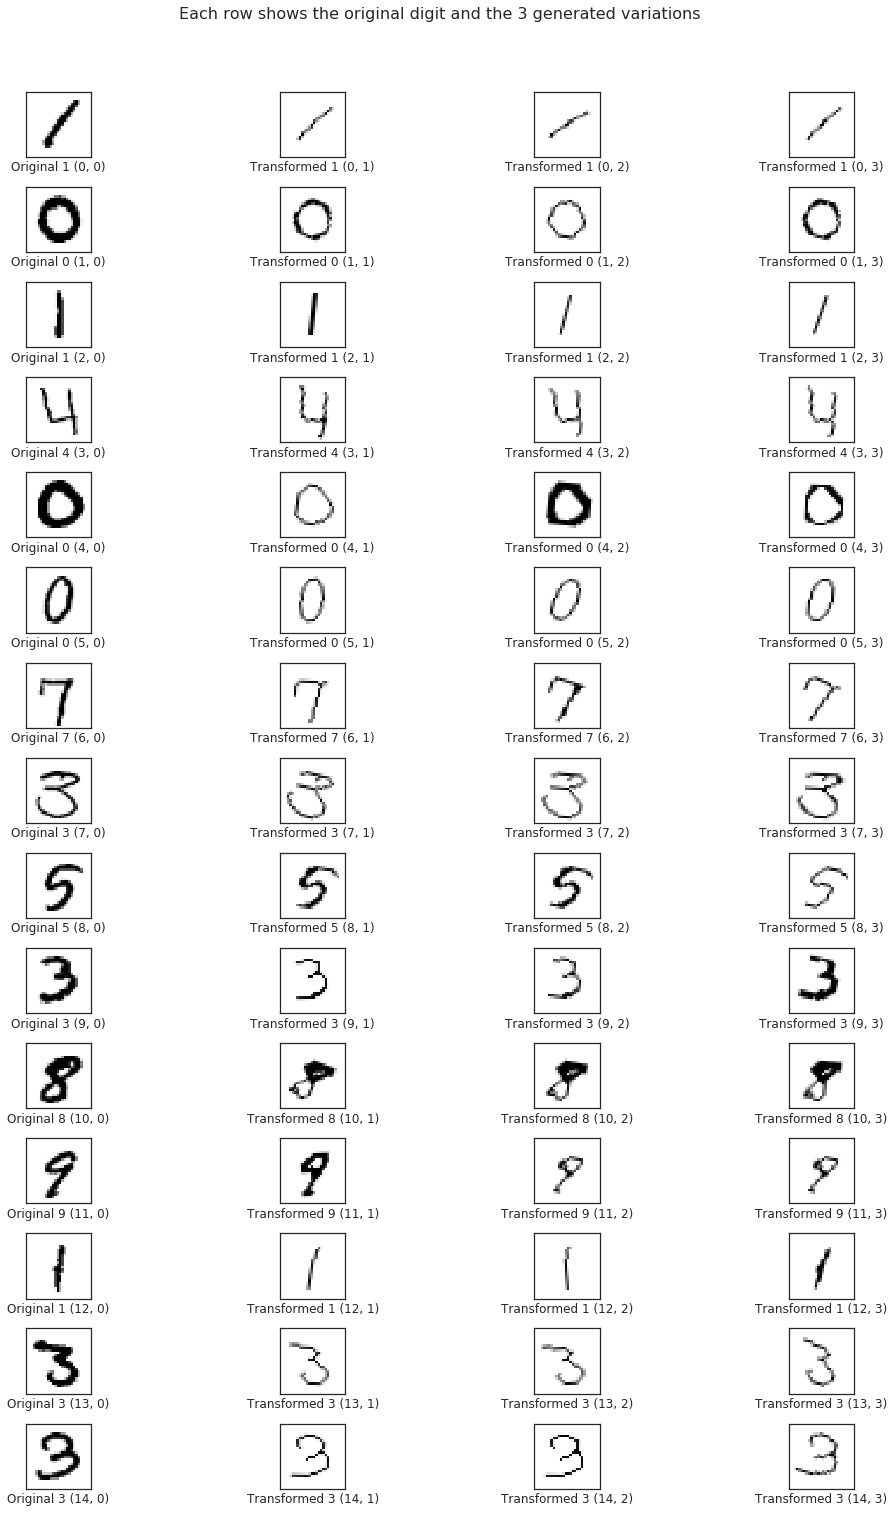

In [23]:
num_rows = 5
num_images_shown = num_repeats * num_rows
figure = plt.figure(figsize=(15, 20))

for i in range(num_images_shown):
    start_index = 1 + i * (num_repeats + 1)
    for j in range(num_repeats + 1):
        plt_index = start_index + j
        plt.subplot(num_images_shown, num_repeats + 1, plt_index)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_index = (j*n) + i
        print('{0} {1} image index {2} plt index {3}'.format(i, j, image_index, plt_index))
        image_label = y_augmented[image_index][0]
        plt.imshow(X_augmented[image_index], cmap=plt.cm.binary)
        if j == 0:
            plt.xlabel('Original {0} ({1}, {2})'.format(image_label, i, j))
        else:
            plt.xlabel('Transformed {0} ({1}, {2})'.format(image_label, i, j))

figure.suptitle('Each row shows the original digit and the {0} generated variations'.format(num_repeats), y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [24]:
# Retrain the neural network
X_augmented_train, X_augmented_validation, y_augmented_train, y_augmented_validation = model_selection.train_test_split(X_augmented, y_augmented, test_size=0.33, random_state=42)
epochs = 100
validation_split = 0.33
model.fit(X_augmented_train, y_augmented_train, epochs=epochs, validation_split=validation_split, callbacks=[earlystop_callback])

Train on 75415 samples, validate on 37145 samples
Epoch 1/100
75415/75415 [==============================] - 16s 209us/sample - loss: 0.2845 - acc: 0.9239 - val_loss: 0.1483 - val_acc: 0.9589
Epoch 2/100
75415/75415 [==============================] - 16s 209us/sample - loss: 0.1858 - acc: 0.9454 - val_loss: 0.1209 - val_acc: 0.9649
Epoch 3/100
75415/75415 [==============================] - 16s 211us/sample - loss: 0.1545 - acc: 0.9539 - val_loss: 0.1097 - val_acc: 0.9682
Epoch 4/100
75415/75415 [==============================] - 15s 205us/sample - loss: 0.1352 - acc: 0.9592 - val_loss: 0.1073 - val_acc: 0.9695
Epoch 5/100
75415/75415 [==============================] - 15s 205us/sample - loss: 0.1196 - acc: 0.9636 - val_loss: 0.1031 - val_acc: 0.9694
Epoch 6/100
75415/75415 [==============================] - 15s 204us/sample - loss: 0.1122 - acc: 0.9651 - val_loss: 0.0980 - val_acc: 0.9723
Epoch 7/100
75415/75415 [==============================] - 15s 203us/sample - loss: 0.1019 - acc: 

In [25]:
# Reevaluate performance
validation_loss, validation_accuracy = model.evaluate(X_augmented_validation, y_augmented_validation, verbose=2)
print("Accuracy: %.4f, Loss: %.4f"%(validation_accuracy, validation_loss))

55440/55440 - 3s - loss: 0.1617 - acc: 0.9745
Accuracy: 0.9745, Loss: 0.1617


In [27]:
X_test, n_test = extract_images_and_labels(testing_data, is_test=True)
X_test_normalized = X_test / 255.0
result = model.predict(X_test_normalized)
predictions = np.apply_along_axis(lambda row: np.argmax(row), 1, result)
predictions.reshape([n_test, 1])
testing_data['Label'] = predictions
testing_data['ImageId'] = list(range(1, n_test + 1))
submission = testing_data[['ImageId', 'Label']]
submission.to_csv('submission.csv', index=False)
submission.tail()

number of images: 28000
Dimensions of images: (28000, 28, 28)


,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [0]:
# apply_along_axis

import numpy as np

n1 = np.array([[0, 0, 1, 2, 3],
                [5, 6, 7, 0, 0]])

In [47]:
n1

array([[0, 0, 1, 2, 3],
       [5, 6, 7, 0, 0]])

In [48]:
n1.shape

(2, 5)

In [49]:
np.min(n1)

0

In [50]:
np.max(n1)

7

In [51]:
np.min(n1[n1>0])

1

In [52]:
np.min(n1, axis=1)

array([0, 0])

In [53]:
np.max(n1, axis=1)

array([3, 7])

In [54]:
np.min(n1, axis=0)

array([0, 0, 1, 0, 0])

In [55]:
np.apply_along_axis(lambda a: np.min(a), 1, n1)

array([0, 0])

In [56]:
np.apply_along_axis(lambda a: np.min(a), 0, n1)

array([0, 0, 1, 0, 0])